# 从wikipidea上下载语料并进行word2vec的训练

## 1.下载语料到本地 

#####  https://dumps.wikimedia.org/zhwiki/20190720/

## 2.下载Wikiexactor提取和清洗数据

##### https://github.com/attardi/wikiextractor

## 3.由于在windows环境下无法使用Wikiexactor工具，安装cygwin的unix虚拟环境

##### https://blog.csdn.net/chunleixiahe/article/details/55666792

## 4.由于语料中繁体和简体同时存在，故在windos下安装开源opencc工具将繁体转换为简体

##### https://blog.csdn.net/sinat_29957455/article/details/81290356

步骤如下：

1.在wikiextractor中创建文件夹result用来存储繁简体转换后的文件

2.在命令行中使用命令来 opencc -i chwiki\AA\wiki_00 -o result\wiki_00.txt -c E:\opencc-1.0.4\share\opencc\t2s.json   -i为输入文件路径 -o 为输出文件路径 -c 为配置文件路径

3.查看文件是否修改成功

## 5.利用jieba和re对数据进行清洗 

In [1]:
import re,jieba,nltk
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE

In [8]:
# 得到stopwords停止词
def get_stopwords():
    return nltk.corpus.stopwords.words() 

In [9]:
# 使用正则表达式和jieba对文件进行清洗
def parse_zhwiki(read_file_path,save_file_path):
    #过滤掉<doc>
    regex_str = "[^<doc.*>$]|[^</doc>$]"
    file = open(read_file_path,"r",encoding="utf-8")
    #写文件
    output = open(save_file_path,"w+",encoding="utf-8")
    content_line = file.readline()
    #获取停用词表
    stopwords = get_stopwords()
     #定义一个字符串变量，表示一篇文章的分词结果
    article_contents = ""
    while content_line:
        match_obj = re.match(regex_str,content_line)
        content_line = content_line.strip("\r\n")
        if len(content_line) > 0:
            if match_obj:
                #使用jieba进行分词
                words = jieba.cut(content_line,cut_all=False)
                for word in words:
                    if word not in stopwords:
                        article_contents += word+" "
            else:
                if len(article_contents) > 0:
                    output.write(article_contents+"\n")
                    article_contents = ""
        content_line = file.readline()
    output.close()

In [10]:
# 对每个简体语料分词后另存储
def generate_corpus():
    for i in range(7):
        fin_filename = 'C:\\Users\\Pinkman\\Desktop\\wikiextractor\\result\\wiki_0{}.txt'.format(i)
        fou_filename =  'C:\\Users\\Pinkman\\Desktop\\wikiextractor\\chwiki\\wiki_corpus{}'.format(i)
        parse_zhwiki(fin_filename,fou_filename)

In [13]:
generate_corpus()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Pinkman\AppData\Local\Temp\jieba.cache
Loading model cost 0.894 seconds.
Prefix dict has been built succesfully.


In [ ]:
# 将所有分词文件存储到一个文件中
fou_name = 'wiki_corpus'
fou = open(fou_name,'w+',encoding = 'utf-8')
for i in range(7):
    fin_name = 'wiki_corpus{}'.format(i)
    fin = open(fin_name,'r',encoding = 'utf-8')
    for line in fin:
        fou.write(line)
    fin.close()
fou.close()

##  6.使用gensim中的word2vec对语料进行训练 

In [3]:
from gensim.models import word2vec

In [13]:
# 使用gensim训练词向量模型
sentences = word2vec.LineSentence("wiki_for_vec")
model = word2vec.Word2Vec(sentences)
#保存模型
model.save("model//wiki_corpus.model")

E:\Anaconda\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [7]:
from gensim import models
model = models.Word2Vec.load('wiki_corpus.model')

## 7.对单词相似度进行测试 

In [8]:
# 输入两个词计算相似度
two_corpus = ["母亲",'妈妈']
two_corpus1 = ['情侣','爱人']
res = model.similarity(two_corpus[0],two_corpus[1])
res1 = model.similarity(two_corpus1[0],two_corpus1[1])
print("similarity:%.4f"%res)
print("similarity:%.4f"%res1)

similarity:0.7315
similarity:0.8391


E:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  after removing the cwd from sys.path.
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """


In [15]:
model.most_similar('数学')

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('物理学', 0.8694803714752197),
 ('科学', 0.8688454031944275),
 ('自然科学', 0.8656834959983826),
 ('物理', 0.861655592918396),
 ('天文学', 0.8547363877296448),
 ('一门', 0.8486872911453247),
 ('自然哲学', 0.8419690132141113),
 ('数论', 0.8315470814704895),
 ('天体力学', 0.8309193849563599),
 ('计算机科学', 0.8301812410354614)]

## 8.将向量降至二维在坐标系中表示

In [9]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


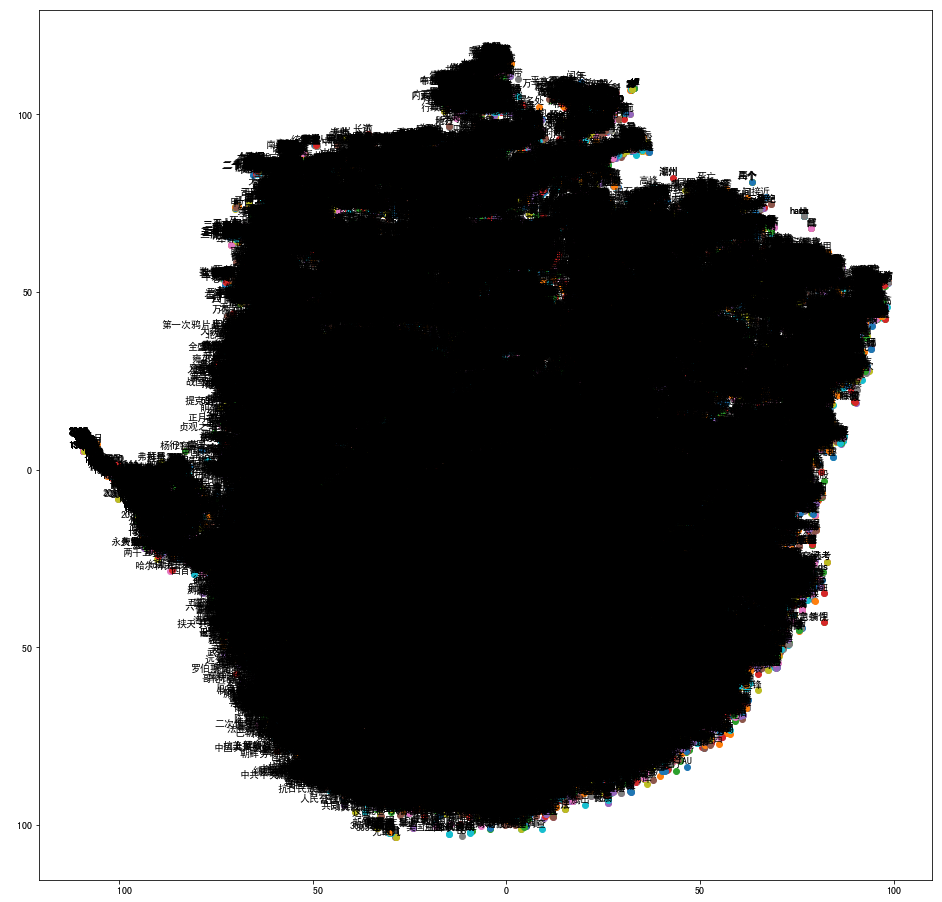

In [14]:
tsne_plot(model)